In [1]:
import numpy as np
import scipy as sp
import pickle
import itertools
import os
from sklearn.model_selection import LeaveOneOut
import tensorly as tl
from scipy.optimize import minimize
import time
import mkl
import matplotlib
from matplotlib import pyplot as plt
mkl.set_num_threads(1)
from matplotlib import rc
import matplotlib.ticker as ticker
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

import sys
from factorizations import tucker_on_error_tensor
from util import missing_ratio
from runtime_generalization import test_tensor_completion, test_matrix_completion

import multiprocessing as mp
from itertools import product

In [367]:
input_path = <folder_that_contains_error_and_runtime_tensors>
output_path = 'tensor_completion_results'

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [368]:
error_tensor = np.load(os.path.join(input_path, 'error_tensor.npy'))
runtime_tensor = np.load(os.path.join(input_path, 'runtime_tensor.npy'))

error_matrix = tl.unfold(error_tensor, mode=0)
runtime_matrix = tl.unfold(runtime_tensor, mode=0)

In [6]:
def approx_rank(A, threshold=0.03, ranks_for_imputation=(20, 4, 2, 2, 8, 20), verbose=False):
    """Compute approximate (matrix) rank of a tensor. Right now this function only supports the calculation of approximte rank of dataset and estimator dimensions. 

    Args:
        A (np.ndarray):    Tensor for which to compute rank.
        threshold (float): All singular values less than threshold * (largest singular value) will be set to 0

    Returns:
        tuple of int: The approximate rank of A in each dimension.
    """
    
    if np.sum(np.isnan(A)):
        _, _, A, _ = tucker_on_error_tensor(A, ranks=ranks_for_imputation, verbose=False)
        
    s0 = sp.linalg.svd(tl.unfold(A, mode=0), compute_uv=False)
    rank0 = len(s0[s0 >= threshold * s0[0]])
    
    s5 = sp.linalg.svd(tl.unfold(A, mode=5), compute_uv=False)
    rank5 = len(s5[s5 >= threshold * s5[0]])    
    
    return (rank0, 4, 2, 2, 8, rank5)

In [29]:
s5 = sp.linalg.svd(tl.unfold(tensor_pred, mode=5), compute_uv=False)
rank5 = len(s5[s5 >= threshold * s5[0]]) 

In [23]:
s0 = sp.linalg.svd(tl.unfold(tensor_pred, mode=0), compute_uv=False)
threshold = 0.03
rank0 = len(s0[s0 >= threshold * s0[0]])

In [11]:
ranks_for_imputation = (20, 4, 2, 2, 8, 20)
_, _, tensor_pred, _ = tucker_on_error_tensor(error_tensor, ranks=ranks_for_imputation, verbose=True)

ranks: (20, 4, 2, 2, 8, 20), iteration 5, error: 84.83201456412196
ranks: (20, 4, 2, 2, 8, 20), iteration 10, error: 83.23619414270657
ranks: (20, 4, 2, 2, 8, 20), iteration 15, error: 82.4890465738238
ranks: (20, 4, 2, 2, 8, 20), iteration 20, error: 82.06368789696816
ranks: (20, 4, 2, 2, 8, 20), iteration 25, error: 81.7062603059036
ranks: (20, 4, 2, 2, 8, 20), iteration 30, error: 81.28601031423807
ranks: (20, 4, 2, 2, 8, 20), iteration 35, error: 81.00724292219105
ranks: (20, 4, 2, 2, 8, 20), iteration 40, error: 80.84298945983996
ranks: (20, 4, 2, 2, 8, 20), iteration 45, error: 80.73191921339908
ranks: (20, 4, 2, 2, 8, 20), iteration 50, error: 80.64988288254075
ranks: (20, 4, 2, 2, 8, 20), iteration 55, error: 80.58554059238313
ranks: (20, 4, 2, 2, 8, 20), iteration 60, error: 80.53268322592687


missing ratio:

In [371]:
missing_ratio(error_tensor)

0.032660002859321385

A plot of ratio of entries:

In [381]:
r = []
r_log_missing = []

# th_to_change = np.arange(2, 122, 2)
th_to_change = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
for th in th_to_change:
    masking_criteria = "runtime_tensor >= {}".format(th)

    masked_indices = np.where(eval(masking_criteria))

    error_tensor_masked = error_tensor.copy()
    error_tensor_masked[eval(masking_criteria)] = np.nan

    r.append(1 - missing_ratio(error_tensor_masked))
    r_log_missing.append(np.log(missing_ratio(error_tensor_masked)))

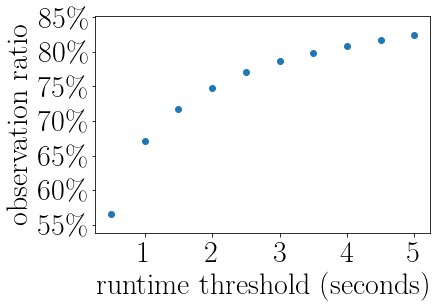

In [384]:
fontsize = 30

plt.scatter(th_to_change, r)
plt.xlabel("runtime threshold (seconds)", fontsize=fontsize)
plt.ylabel("observation ratio", fontsize=fontsize)
# plt.title("ratio of entries with running time lower than a threshold", fontsize=fontsize)
# ytick_pos = np.arange(0.75, 1.00, 0.05)

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.yticks(ytick_pos, fontsize=fontsize)

fig_dir = 'figs'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
# plt.savefig(os.path.join(fig_dir, 'missing_ratios.pdf'), bbox_inches='tight')
# plt.savefig(os.path.join(output_path, "observation_ratio.pdf"), bbox_inches='tight')

tensor and matrix completion settings

In [4]:
runtime_threshold = 90

In [5]:
masking_criteria = "runtime_tensor >= {}".format(runtime_threshold)

masked_indices = np.where(eval(masking_criteria))

error_tensor_masked = error_tensor.copy()
error_tensor_masked[eval(masking_criteria)] = np.nan

missing_ratio(error_tensor_masked)

0.040427627398652945

tensor completion (parallel)

In [6]:
dataset_ranks = np.arange(1, 41, 1)
runtime_threshold = np.arange(5, 125, 5)

ranks_product = [(dataset_rank, dataset_rank) for dataset_rank in dataset_ranks]
ranks_and_threshold_product = list(product(ranks_product, runtime_threshold))

In [7]:
# ranks_for_imputation_all = [(rank, 4, 2, 2, 8, rank) for rank in ranks_to_enumerate]

imputation_settings_all = [((pair[0], 4, 2, 2, 8, pair[1]), runtime_threshold) for pair, runtime_threshold in ranks_and_threshold_product]

In [ ]:
p1 = mp.Pool(100)
result_tensor = [p1.apply_async(test_tensor_completion, args=[error_tensor, runtime_tensor, ranks_for_imputation, runtime_threshold, False]) 
          for ranks_for_imputation, runtime_threshold in imputation_settings_all]
p1.close()
p1.join()

result_tensor = [item.get() for item in result_tensor]

ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 5
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 10
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 15
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 20
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 25
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 30
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 35
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 40
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 45
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 50
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 55
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 60
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 65
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 70
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 75
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 80
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 85
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 90
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 95
ranks: (1, 4, 2, 2, 8, 1), runtime_threshold: 100
ranks: (1, 4, 2, 2, 

ranks: (7, 4, 2, 2, 8, 7), runtime_threshold: 120
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 5
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 10
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 15
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 20
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 25
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 30
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 35
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 40
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 45
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 50
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 55
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 60
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 65
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 70
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 75
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 80
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 85
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 90
ranks: (8, 4, 2, 2, 8, 8), runtime_threshold: 95
ranks: (8, 4, 2, 2, 

ranks: (14, 4, 2, 2, 8, 14), runtime_threshold: 95
ranks: (14, 4, 2, 2, 8, 14), runtime_threshold: 100
ranks: (14, 4, 2, 2, 8, 14), runtime_threshold: 105
ranks: (14, 4, 2, 2, 8, 14), runtime_threshold: 110
ranks: (14, 4, 2, 2, 8, 14), runtime_threshold: 115
ranks: (14, 4, 2, 2, 8, 14), runtime_threshold: 120
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 5
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 10
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 15
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 20
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 25
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 30
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 35
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 40
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 45
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 50
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 55
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 60
ranks: (15, 4, 2, 2, 8, 15), runtime_threshold: 65
ranks: (15, 4, 2, 2, 8, 15)

ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 60
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 65
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 70
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 75
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 80
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 85
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 90
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 95
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 100
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 105
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 110
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 115
ranks: (21, 4, 2, 2, 8, 21), runtime_threshold: 120
ranks: (22, 4, 2, 2, 8, 22), runtime_threshold: 5
ranks: (22, 4, 2, 2, 8, 22), runtime_threshold: 10
ranks: (22, 4, 2, 2, 8, 22), runtime_threshold: 15
ranks: (22, 4, 2, 2, 8, 22), runtime_threshold: 20
ranks: (22, 4, 2, 2, 8, 22), runtime_threshold: 25
ranks: (22, 4, 2, 2, 8, 22), runtime_threshold: 30
ranks: (22, 4, 2, 2, 8, 22)

ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 25
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 30
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 35
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 40
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 45
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 50
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 55
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 60
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 65
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 70
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 75
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 80
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 85
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 90
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 95
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 100
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 105
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 110
ranks: (28, 4, 2, 2, 8, 28), runtime_threshold: 115
ranks: (28, 4, 2, 2, 8, 28)

In [ ]:
result_tensor_dict = dict(zip(imputation_settings_all, result_tensor))

In [ ]:
result_path = 'tensor_completion_results'
if not os.path.exists(result_path):
    os.makedirs(result_path)
with open(os.path.join(result_path, 'result_tensor_completion.pkl'), 'wb') as f:
    pickle.dump(result_tensor_dict, f)

save results

In [212]:
# for rank in result_tensor_dict:
#     np.save(os.path.join(output_path, str(runtime_threshold), "{}.npy".format(rank)), 
#             result_tensor_dict[rank])

matrix completion (parallel)

In [213]:
# ranks_to_enumerate = np.arange(10, 210, 10)
ranks_to_enumerate_matrix = np.arange(1, 41, 1)
runtime_threshold_matrix = np.arange(5, 125, 5)
ranks_and_threshold_product_matrix = list(product(ranks_to_enumerate_matrix, runtime_threshold_matrix))

In [ ]:
# imputation_settings_all = [((pair[0], 4, 2, 2, 8, pair[1]), runtime_threshold) for pair, runtime_threshold in ranks_and_threshold_product]

In [214]:
p2 = mp.Pool(100)
result_matrix = [p2.apply_async(test_matrix_completion, args=[error_matrix, runtime_matrix, rank, runtime_threshold, False])
          for rank, runtime_threshold in ranks_and_threshold_product_matrix]
p2.close()
p2.join()

result_matrix = [item.get() for item in result_matrix]

rank: 1
rank: 3
rank: 4
rank: 2
rank: 5
rank: 6
rank: 7
rank: 8
rank: 9
rank: 10
rank: 11
rank: 12
rank: 13
rank: 14
rank: 15
rank: 16
rank: 17
rank: 18
rank: 19
rank: 20
rank: 21
rank: 22
rank: 23
rank: 24
rank: 25
rank: 26
rank: 27
rank: 28
rank: 29
rank: 30
rank: 31
rank: 32
rank: 33
rank: 34
rank: 35
rank: 36
rank: 37
rank: 38
rank: 39
rank: 40


In [ ]:
result_matrix_dict = dict(zip(ranks_and_threshold_product_matrix, result_matrix))

In [ ]:
result_path = 'tensor_completion_results'
if not os.path.exists(result_path):
    os.makedirs(result_path)
with open(os.path.join(result_path, 'result_matrix_completion.pkl'), 'wb') as f:
    pickle.dump(result_matrix_dict, f)

read

In [ ]:
with open(os.path.join(result_path, 'result_tensor_completion.pkl'), 'rb') as handle:
    result_tensor_dict = pickle.load(handle)
    
with open(os.path.join(result_path, 'result_matrix_completion.pkl'), 'rb') as handle:
    result_matrix_dict = pickle.load(handle)

In [199]:
dataset_ranks = np.arange(1, 41, 1)
runtime_threshold = np.arange(5, 125, 5)

In [200]:
dataset_ranks_to_plot = np.arange(1, 41, 1)
runtime_threshold_to_plot = np.arange(5, 115, 5)


ratios_tensor_to_matrix = np.full((len(runtime_threshold_to_plot), len(dataset_ranks_to_plot)), np.nan)
result_tensor_2D = np.full((len(runtime_threshold_to_plot), len(dataset_ranks_to_plot)), np.nan)
result_matrix_2D = np.full((len(runtime_threshold_to_plot), len(dataset_ranks_to_plot)), np.nan)

for idx_t, t in enumerate(runtime_threshold_to_plot):
    for idx_r, r in enumerate(dataset_ranks_to_plot):        
        result_tensor_2D[idx_t, idx_r] = result_tensor_dict[((r, 4, 2, 2, 8, r), t)]
        result_matrix_2D[idx_t, idx_r] = result_matrix_dict[(r, t)]
        ratios_tensor_to_matrix[idx_t, idx_r] = result_tensor_2D[idx_t, idx_r] / result_matrix_2D[idx_t, idx_r]

In [351]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", fontsize=20, vmin=0.4, vmax=1.6, **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=vmin, vmax=vmax, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.tick_params(labelsize=fontsize) 
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=fontsize)
#     cbar.set_label('matrix better', labelpad=-20, y=-1, rotation=0)
#     cbar.ax.text(2.5, 0.5, "SECONDLABEL", rotation=0, va='center') 
#     cbar.set_label('tensor better', labelpad=-20, y=-1, rotation=0)
#     cbar.ax.set_title('matrix better')
    
    ax.set_xlabel('dataset and estimator ranks', fontsize=fontsize)
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('runtime threshold (seconds)', fontsize=fontsize)
    
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
#     ax.locator_params(axis='x', nbins=13)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    return im, cbar


In [352]:
row_labels

[5, 10, 15, 20, 25, 30, 35, 40]

In [353]:
runtime_threshold_to_plot

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110])

In [355]:
dataset_ranks_to_plot = np.arange(1, 41)

In [356]:
row_labels = [5, 10, 15, 20, 25, 30, 35, 40]
r = []
row_labels_to_plot = np.array([i if i in row_labels else np.nan for i in dataset_ranks_to_plot])

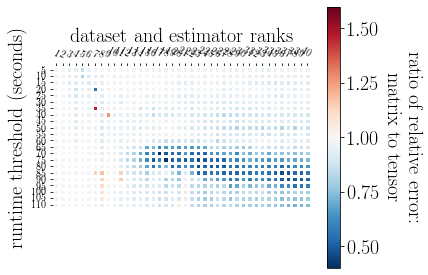

In [357]:
fig, ax = plt.subplots()

im, cbar = heatmap(ratios_tensor_to_matrix, runtime_threshold_to_plot, dataset_ranks_to_plot, ax=ax,
                   cmap="RdBu_r", vmin=0.4, vmax=1.6, cbarlabel="ratio of relative error:\n matrix to tensor")
# texts = annotate_heatmap(im, valfmt="{x:.1f} t")
fig.tight_layout()

fig_dir = 'figs'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

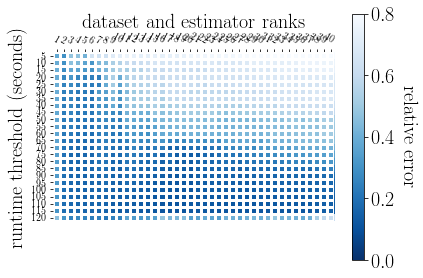

In [172]:
fig, ax = plt.subplots()

im, cbar = heatmap(result_tensor_2D, runtime_threshold_to_plot, dataset_ranks_to_plot, ax=ax,
                   cmap="Blues_r", vmin=0, vmax=0.8, cbarlabel="relative error")
# texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()

fig_dir = 'figs'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
fig.savefig(os.path.join(fig_dir, 'tensor_heatmap.pdf'), bbox_inches='tight')

In [189]:
from matplotlib import cm
cm.Blues(255)

(0.03137254901960784, 0.18823529411764706, 0.4196078431372549, 1.0)

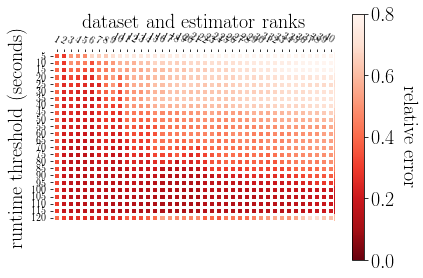

In [173]:
fig, ax = plt.subplots()

im, cbar = heatmap(result_matrix_2D, runtime_threshold_to_plot, dataset_ranks_to_plot, ax=ax,
                   cmap="Reds_r", vmin=0, vmax=0.8, cbarlabel="relative error")
# texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()

fig_dir = 'figs'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
fig.savefig(os.path.join(fig_dir, 'matrix_heatmap.pdf'), bbox_inches='tight')

In [360]:
t = 90
r_tensor = []
r_matrix = []

for idx_r, r in enumerate(dataset_ranks_to_plot):
    r_tensor.append(result_tensor_dict[((r, 4, 2, 2, 8, r), t)])
    r_matrix.append(result_matrix_dict[(r, t)])

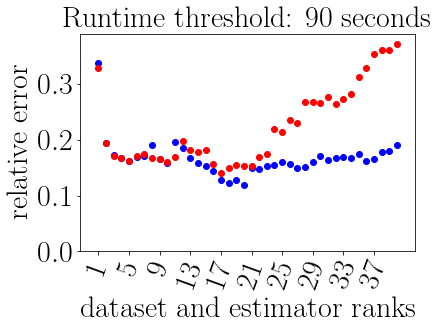

In [364]:
fontsize = 30
legend_marker_size = 20

plt.scatter(dataset_ranks_to_plot, r_tensor, c='b', label='tensor completion')
plt.scatter(dataset_ranks_to_plot, r_matrix, color='r', label='matrix completion')
plt.xticks(dataset_ranks_to_plot, rotation='vertical', fontsize=9)
plt.xlabel('dataset and estimator ranks', fontsize=fontsize)
plt.ylabel('relative error', fontsize=fontsize)
plt.xticks(fontsize=fontsize, rotation=70)
plt.yticks([0, 0.1, 0.2, 0.3], fontsize=fontsize)
plt.locator_params(axis='x', nbins=13)
plt.title('Runtime threshold: {} seconds'.format(t), fontsize=fontsize)
# plt.legend(fontsize=fontsize)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=2, fontsize=legend_marker_size)


plt.savefig(os.path.join(fig_dir, "relative_error_{}.pdf".format(t)), bbox_inches='tight')